# Do NOT GRADE ON 12/2. UPDATE IN PROGRESS

## Introduction
In this notebook, we will perform anomaly detection on a dataset the examines the volume of tweet mentions received by Google in 5 minute intervals. This could be useful in the real world because Twitter is the first place customers go to complain. Therefore, if there are an unusually high number of mentions (without a major product launch or other big event), there could be an issue with the service that needs to be attended to immediately. Having an anomaly detection model could notice this pattern and alert the appropriate individuals.

### 1) Data Preprocessing & Cleaning

In [1]:
import numpy as np
import pandas as pd

original = pd.read_csv("../data/Twitter_volume_GOOG.csv", index_col=[0], parse_dates=[0])
print(original.head(5))

                     value
timestamp                 
2015-02-26 21:42:53     35
2015-02-26 21:47:53     41
2015-02-26 21:52:53     32
2015-02-26 21:57:53     36
2015-02-26 22:02:53     32


In [2]:
original.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15842 entries, 2015-02-26 21:42:53 to 2015-04-22 21:47:53
Data columns (total 1 columns):
value    15842 non-null int64
dtypes: int64(1)
memory usage: 247.5 KB


Notice that the timestamp column is not a datetime. We want to convert this to a datetime so we can group all of the tweets in one day together to get a consistent time period for comparison. The sum of each day's tweets will become the value.

In [3]:
original = original.resample('H').sum()
original.head()

# original['timestamp'] = pd.to_datetime(original['timestamp']) 
# original.sort_values(['timestamp'], inplace=True)

# original['hour'] = original['timestamp'].dt.hour

# groupedDate = pd.DataFrame(original['timestamp'].dt.date)
# groupedDate['hour'] = original['hour']
# groupedDate['value'] = original['value']
# groupedDate.groupby(['value']).head()

,value
timestamp,
2015-02-26 21:00:00,144
2015-02-26 22:00:00,365
2015-02-26 23:00:00,332
2015-02-27 00:00:00,581
2015-02-27 01:00:00,387


/Users/michael.svoren/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


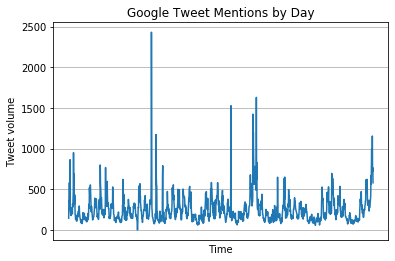

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

fig, ax = plt.subplots()
ax.plot(original.index, original['value'])
years = mdates.YearLocator()
yearsFmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)


ax.set(xlabel='Time', ylabel='Tweet volume',
       title='Google Tweet Mentions by Day')
ax.grid()
plt.show()


We grouped the data by days to simplify its graphical appearance. As can be seen in the graph, which graphs 3 months of data, there are several extreme outliers that would be considered anomalies. Additionally, there doesn't appear to be a trend that we need to consider over the course of the three months. 

### 2) Models and Results
Next we will generate models to predict them. There are not many features and we can even throw out the date, so as to solely focus on the tweet volume in both a stastical way and classification model. First, we will do an interquartile range. This is a quick statistical method that is an effective way to group data and is easy to understand.

In [6]:
q75, q25 = np.percentile(original['value'], [75 ,25])
iqr = q75 - q25
totalMedian = original['value'].median()
print('Median: ' + str(totalMedian))
print('Interquartile Range: ' + str(iqr))
print('Q25: ' + str(q25))
print('Q75: ' + str(q75))

Median: 200.0
Interquartile Range: 159.0
Q25: 144.0
Q75: 303.0


Now that we have the interquartile range, we can find the outliers by using the 1.5xIQR rule. The rule states that if a data point is more than 1.5 * IQR below the first quartile or above the third quartile, then it is an outlier. Let's calculate those threshholds below.

In [7]:
#low bound
low = q25 - 1.5 * iqr
high = q75 + 1.5 * iqr
print('Low Outliers are below: ' + str(low))
print('High Outliers are above: ' + str(high))

count = original.count()
highCount = original[original['value'] > high].count()
print('Outliers to normal ratio: ' + str(highCount / count))

Low Outliers are below: -94.5
High Outliers are above: 541.5
Outliers to normal ratio: value    0.049962
dtype: float64


Since the low outliers are negative and we have no negative numbers in the dataset, only the high outlier number (48.5) is relevant. This means that if there are at least 49 tweets in a 5 minute period mentioning Google, then we can claim that is an outlier. That includes 5.28% of data in this dataset.

                     value
timestamp                 
2015-02-26 21:00:00    144
2015-02-26 22:00:00    365
2015-02-26 23:00:00    332
2015-02-27 00:00:00    581
2015-02-27 01:00:00    387


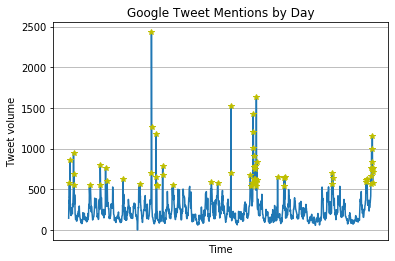

In [40]:
fig, ax = plt.subplots()
ax.plot(original.index, original['value'])
years = mdates.YearLocator()
yearsFmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)

print(original.head())
ax.set(xlabel='Time', ylabel='Tweet volume',
       title='Google Tweet Mentions by Day')
ax.grid()
for i, row in original.iterrows():
    if (row['value'] >= high):
        ax.plot(i, original['value'][i], 'y*')
plt.show()


#plt.plot(x[mask2], y[mask2], 'x')

Next, lets train a clustering model to do the anomaly detection. We will generate two clusters, one which should represent the outliers and one which should represent the normal values. The KMeans algorithm is quick and fairly accurate on datasets with limited features, so it is a good choice here. To vocalize the obvious concept, most of the data should center around the mean, which represents the normal values, while outlier data, since it will likely only be upper outliers as a conclusion of the analysis above with the interquartile range, will cluster around a higher value.

In [ ]:
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

x = original.as_matrix(columns=['value']).astype('int')

postCluster = original

kmeans = KMeans(n_clusters=2, random_state=0).fit_predict(x)
postCluster['Cluster'] = kmeans
postCluster.head()

cluster1Count = postCluster['Cluster'][postCluster['Cluster'] ==0].count()
print('Outlier Count')
print(str(cluster1Count))
cluster2Count = postCluster['Cluster'][postCluster['Cluster'] ==1].count()
print('Normal Count')
print(str(cluster2Count))

print('Ratio')
print(str(cluster1Count / cluster2Count))

The result of the clustering algorithm shows that we have almost 16% of the data as an outlier, which is quite reasonable given the interquartile range yielded just over 5%. We can take the average of each cluster to show where the clusters are centered.

In [ ]:
average1 = groupedDate['value'][groupedDate['Cluster'] ==0].mean()
average2 = groupedDate['value'][groupedDate['Cluster'] ==1].mean()

print('Outlier Average:')
print(average1)
print('Normal Average:')
print(average2)

It's apparent that the 61.7 outlier average is much higher than the normal average. This is expected.

### 3) Conclusion
The two methods we used to detect anomalies both yielded similar results, giving a high confidence that they are accurate. Of course, we were using data which didn't have labels (anomaly or no-anomaly), so the two models have slightly different thresholds for what is considered an anomaly or not, observable by looking at the 10% vs 5% outlier rate. Extensions would be using other types of models such as random or isolation forest. However, since we were on using one feature, KMeans clustering appeared to work the best. We could not do classification because the data was unlabeled.